<a href="https://colab.research.google.com/github/fillipesansilva/machine-learning-in-practice/blob/master/Desafio_corteva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Objetivo do teste 1**

Usar a aba dataset 
1. Criar um modelo usando SVM pra prever
    1.   previsao A ( coluna G do dataset) - resultado deve ser numerico
    2.   previsao B ( coluna H do dataset) - resultado deve ser categorico


**Importante:** 

1. Balancear as classes antes de criar o modelo
2. Usar as features para tentar prever a. e b.
3. Testar mais de um kernel
4. reportar a acuracia balanceada no conjunto de validacao
5. Dividir os dados em treino e validacao  (80 e20)

In [ ]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve

In [ ]:
xls = pd.ExcelFile("/content/drive/My Drive/Colab Notebooks/datasets/desafio-cientista-de-dados.xlsx")
df = pd.read_excel(xls, 'Dataset')
df.head()


,FEATURE 6,FEATURE 5,FEATURE 4,FEATURE 1,FEATURE 2,FEATURE 3,Previsao A,Previsao B,Unnamed: 8,Unnamed: 9
0,2020-01-03,12:06:57,C021K13101,1180227,109B1L,10.060,"0,955",BOM,NaN,NaN
1,2020-01-03,21:19:00,C021K13102,1180227,109B1L,10.052,"0,955",BOM,NaN,NaN
2,2020-01-04,13:34:55,C021K14101,1180227,109B1L,10.040,"0,955",BOM,NaN,NaN
3,2020-01-04,17:30:46,C021K14102,1180227,109B1M,10.028,"0,955",BOM,NaN,NaN
4,2020-01-04,23:05:04,C021K14103,1180227,109B1M,10.067,"0,955",BOM,NaN,NaN


Formatação 1

In [ ]:
df = df.rename(columns={"FEATURE 6": "date", 
                        "FEATURE 5": "time",
                        "FEATURE 4": "f4",
                        "FEATURE 1": "f1",
                        "FEATURE 2": "f2",
                        "FEATURE 3": "f3",
                        "Previsao A": "prevA",
                        "Previsao B": "prevB"     
                        })
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()

df.date = pd.to_datetime(df.date)
df.date = df.date.apply(lambda x : x.timestamp())

#df.time = pd.to_datetime(df.time,format= '%H:%M:%S' ).dt.time
df['time'] = df['time'].astype('str').apply(lambda x: x.split(':')[0]).astype('int')

df['prevB'] = df['prevB'].map({'BOM': 1.0, 'RUIM': 0.0})
df['prevA'] = df['prevA'].apply(lambda x: x.replace(',','.')).astype('float')

df['f1'] = df['f1'].map( dict(zip(df.f1.unique(), range(0,len(df.f1.unique())))))
df['f2'] = df['f2'].map( dict(zip(df.f2.unique(), range(0,len(df.f2.unique())))))
df['f4'] = df['f4'].map( dict(zip(df.f4.unique(), range(0,len(df.f4.unique())))))

#df = (df - df.min())/(df.max()-df.min())

df

,date,time,f4,f1,f2,f3,prevA,prevB
0,1.578010e+09,12,0,0,0,10.060,0.955,1.0
1,1.578010e+09,21,1,0,0,10.052,0.955,1.0
2,1.578096e+09,13,2,0,0,10.040,0.955,1.0
3,1.578096e+09,17,3,0,1,10.028,0.955,1.0
4,1.578096e+09,23,4,0,1,10.067,0.955,1.0
...,...,...,...,...,...,...,...,...
174,1.583194e+09,3,174,1,0,10.051,0.955,1.0
175,1.583194e+09,6,175,1,0,10.050,0.955,0.0
176,1.583194e+09,10,176,1,0,10.074,0.955,0.0
177,1.583194e+09,19,177,1,0,10.050,0.955,0.0


In [ ]:
df.dtypes

date     float64
time       int64
f4         int64
f1         int64
f2         int64
f3       float64
prevA    float64
prevB    float64
dtype: object

{'boxes': [<matplotlib.lines.Line2D at 0x7f385cdb9cf8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f385cdcd748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f385cd57208>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f385cdcde48>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f385cdcd048>,
  <matplotlib.lines.Line2D at 0x7f385cdcd3c8>]}

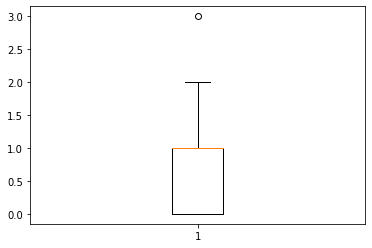

In [ ]:
plt.boxplot(df['f1'])


In [ ]:
df = df.drop(df[df['f1']>=2.5].index)

{'boxes': [<matplotlib.lines.Line2D at 0x7f385cd4f710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f385c890160>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f385c890be0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f385c890860>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f385cd4fa20>,
  <matplotlib.lines.Line2D at 0x7f385cd4fda0>]}

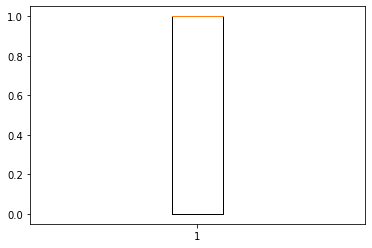

In [ ]:
plt.boxplot(df['f2'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f385cd310b8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f385c8a8c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f385c8b3a58>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f385c8b3048>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f385c8c2ac8>,
  <matplotlib.lines.Line2D at 0x7f385c89b6d8>]}

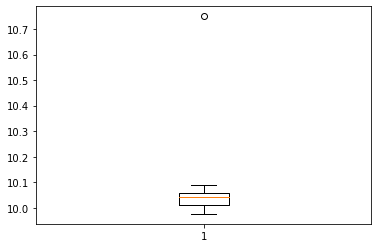

In [ ]:
plt.boxplot(df['f3'])

In [ ]:
df = df.drop(df[df['f3']>=10.5].index)

In [ ]:
df.head(5)

,date,time,f4,f1,f2,f3,prevA,prevB
0,1.578010e+09,12,0,0,0,10.060,0.955,1.0
1,1.578010e+09,21,1,0,0,10.052,0.955,1.0
2,1.578096e+09,13,2,0,0,10.040,0.955,1.0
3,1.578096e+09,17,3,0,1,10.028,0.955,1.0
4,1.578096e+09,23,4,0,1,10.067,0.955,1.0


In [ ]:
df['f1'].value_counts(normalize=True)*100
df['f2'].value_counts(normalize=True)*100
df['f3'].value_counts(normalize=True)*100
df['f4'].value_counts(normalize=True)*100
df

,date,time,f4,f1,f2,f3,prevA,prevB
0,1.578010e+09,12,0,0,0,10.060,0.955,1.0
1,1.578010e+09,21,1,0,0,10.052,0.955,1.0
2,1.578096e+09,13,2,0,0,10.040,0.955,1.0
3,1.578096e+09,17,3,0,1,10.028,0.955,1.0
4,1.578096e+09,23,4,0,1,10.067,0.955,1.0
...,...,...,...,...,...,...,...,...
174,1.583194e+09,3,174,1,0,10.051,0.955,1.0
175,1.583194e+09,6,175,1,0,10.050,0.955,0.0
176,1.583194e+09,10,176,1,0,10.074,0.955,0.0
177,1.583194e+09,19,177,1,0,10.050,0.955,0.0


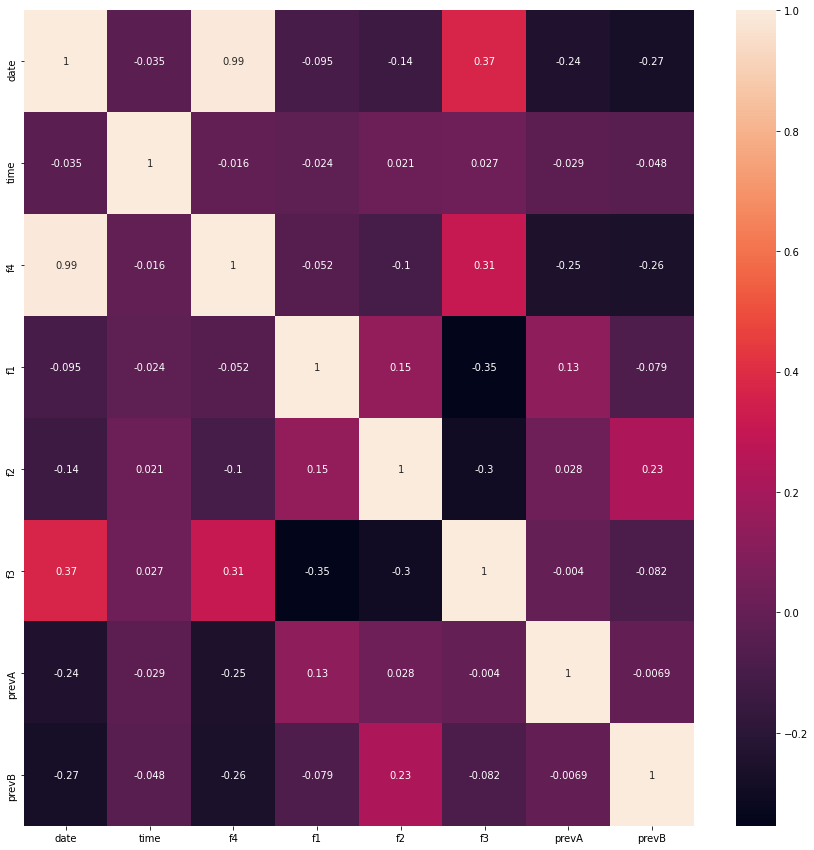

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

In [ ]:
X = df.drop(["prevA", "prevB", "date", "time", "f2"], axis ="columns")
X

,f4,f1,f3
0,0,0,10.060
1,1,0,10.052
2,2,0,10.040
3,3,0,10.028
4,4,0,10.067
...,...,...,...
174,174,1,10.051
175,175,1,10.050
176,176,1,10.074
177,177,1,10.050


In [ ]:
y = df.prevA
y

0      0.955
1      0.955
2      0.955
3      0.955
4      0.955
       ...  
174    0.955
175    0.955
176    0.955
177    0.955
178    0.955
Name: prevA, Length: 177, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
parameters = [{'kernel': ['poly', 'linear', 'rbf'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [ 1e-4, 1e-3]}]
clf = GridSearchCV(svm.SVR(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001],
                          'kernel': ['poly', 'linear', 'rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print(clf.best_params_)

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}


In [ ]:
print(clf.best_score_)

-0.05787933218500259


In [ ]:
pred_clf = clf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,pred_clf)

1.2499999999999592e-06

In [ ]:
y_test = y_test.reset_index()

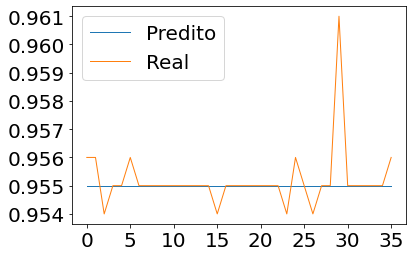

In [ ]:
pred_clf = pd.DataFrame(pred_clf)

pd.concat([ pred_clf, y_test.prevA], axis = 1).plot(linewidth = 1,  fontsize=20)
plt.legend(["Predito","Real"], fontsize=20)
plt.show()


### **Classificação**

In [ ]:
X = df.drop(["prevA", "prevB", "date", "time", "f3",  "f1"], axis ="columns")
X

,f4,f2
0,0,0
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
174,174,0
175,175,0
176,176,0
177,177,0


In [ ]:
y = df.prevB
y

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
174    1.0
175    0.0
176    0.0
177    0.0
178    0.0
Name: prevB, Length: 177, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
clf = GridSearchCV(svm.SVC(), parameters)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001],
                          'kernel': ['poly', 'linear', 'rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
classificao = clf.predict(X_test)

In [ ]:
acuracia = accuracy_score(y_test,classificao)
acuracia

1.0

In [ ]:
precisao = precision_score(y_test,classificao)
precisao

1.0

In [ ]:
recall = recall_score(y_test,classificao)
recall

1.0

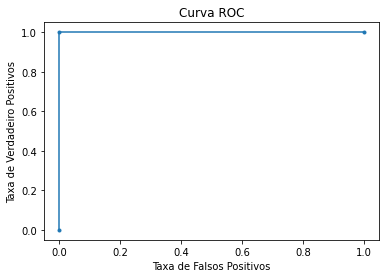

In [ ]:
fpr, tpr, _ = roc_curve(y_test,classificao)
plt.plot(fpr,tpr,marker='.')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.show()

## **Conclusão** 
1. Os valores para X e y foram baseados na matrix correlação.
2. Poderia aplicar técnicas para cirar mais valores e melhorar o modelo (nao deu tempo).
